[*********************100%***********************]  1 of 1 completed
             Open   High     Low  Close    Volume
Date                                             
2000-01-03  111.0  111.5  107.50  108.0   3908164
2000-01-04  106.0  106.5  105.00  106.0   6895378
2000-01-05  101.0  102.0   99.50  100.5  14657098
2000-01-06  101.0  102.0   96.25   97.0  10632084
2000-01-07   98.5  101.0   97.50  100.5   8368286
Training data set size - 4024
Test data set size - 1006
Length of inputs 3964
length of time-series - inputs (3964, 60, 5)
length of time-series - outputs (3964,)
Batch trimmed size (3950, 60, 5) (3950,)
Length of inputs 946
length of time-series - inputs (946, 60, 5)
length of time-series - outputs (946,)
Test size (450, 60, 5) (450,) (450, 60, 5) (450,)
Building model...


/home/gordon/anaconda3/envs/FYP/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (50, 60, 100)             42400     
                                                                 
 lstm_5 (LSTM)               (50, 60)                  38640     
                                                                 
 dense_4 (Dense)             (50, 20)                  1220      
                                                                 
 dense_5 (Dense)             (50, 1)                   21        
                                                                 
Total params: 82,281
Trainable params: 82,281
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50


/home/gordon/anaconda3/envs/FYP/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/home/gordon/anaconda3/envs/FYP/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Shape of y_pred_back - (49, 1)


AttributeError: in user code:

    File "/tmp/ipykernel_2291/2482768708.py", line 172, in custom_loss  *
        direction_loss = tf.scatter_nd_update(direction_loss, indices, alpha*updates)

    AttributeError: module 'tensorflow' has no attribute 'scatter_nd_update'


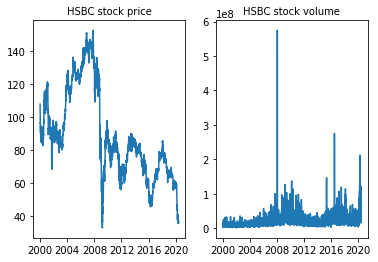

In [3]:
import numpy as np
np.random.seed(1) # for reproducibility

import keras.backend as K
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
import time
import os
import pickle
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizer_v2.adam import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
tf.config.run_functions_eagerly(True)

'''Step 1 - Download stock price data from yahoo finance'''
#HSBC
hsbc = yf.download('0005.HK', '2000-01-01', '2020-05-31')
hsbc = hsbc.drop(['Adj Close'], axis=1)
#remove row with volume = 0
hsbc = hsbc.drop(hsbc[hsbc.Volume==0].index)
print(hsbc.head())


'''Step 2 - Plot stock price & volume'''
fig, (ax1, ax2) = plt.subplots(1, 2)
#stock price
ax1.set_title('HSBC stock price', fontsize=10)
ax1.plot(hsbc['Close'])
#volume
ax2.set_title('HSBC stock volume', fontsize=10)
ax2.plot(hsbc["Volume"])


'''Step 3 - Split data into training set and test set'''
train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(hsbc, train_size=0.8, test_size=0.2, shuffle=False)
print("Training data set size -", len(df_train))
print("Test data set size -", len(df_test))


'''Step 4 - Scale feature MinMax  - Train the scaler with training data and smooth data'''
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])


'''Step 5 - Set environment parameters'''
#Show warning & error
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


'''Step 6 - Set model parameters'''
#set parameters for model
params = {
    "BATCH_SIZE": 50,
    "EPOCHS": 50,
    "LR": 0.00010000,
    "TIME_STEPS": 60
    }

#path to input & output
PATH_TO_DRIVE = 'YOUR OWN DIRECTORY PATH'
INPUT_PATH = PATH_TO_DRIVE + '\\inputs'
OUTPUT_PATH = PATH_TO_DRIVE  + '\\outputs'
TIME_STEPS = params['TIME_STEPS']
BATCH_SIZE = params['BATCH_SIZE']
stime = time.time()


# check if directory already exists
#if not os.path.exists(OUTPUT_PATH):
#    os.makedirs(OUTPUT_PATH)
#    print("Directory created", OUTPUT_PATH)

#else:
#    raise Exception("Directory already exists. Don't override.")


def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ", np.round(seconds%60),"seconds")


'''Step 7 - Filtering datasets for training model'''

def trim_dataset(mat, batch_size):
    
    #trims dataset to a size that's divisible by BATCH_SIZE
    no_of_rows_drop = mat.shape[0] % batch_size

    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat


'''Step 8 - Transform data into time series format'''

def build_timeseries(mat, y_col_index):
    
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]

    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))

    print("Length of inputs", dim_0)

    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]

    print("length of time-series - inputs", x.shape)
    print("length of time-series - outputs", y.shape)

    return x, y

x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size", x_t.shape, y_t.shape)


'''Step 9 - Construct customized loss function for training'''
def custom_loss(y_true, y_pred):
    
    #extract the "next day's price" of tensor
    y_true_next = y_true[1:]
    y_pred_next = y_pred[1:]
    
    #extract the "today's price" of tensor
    y_true_tdy = y_true[:-1]
    y_pred_tdy = y_pred[:-1]
    
    print('Shape of y_pred_back -', y_pred_tdy.get_shape())
    
    #substract to get up/down movement of the two tensors
    y_true_diff = tf.subtract(y_true_next, y_true_tdy)
    y_pred_diff = tf.subtract(y_pred_next, y_pred_tdy)
        
    #create a standard tensor with zero value for comparison
    standard = tf.zeros_like(y_pred_diff)
    
    #compare with the standard; if true, UP; else DOWN
    y_true_move = tf.greater_equal(y_true_diff, standard)
    y_pred_move = tf.greater_equal(y_pred_diff, standard)
    y_true_move = tf.reshape(y_true_move, [-1])
    y_pred_move = tf.reshape(y_pred_move, [-1])
    

    #find indices where the directions are not the same
    condition = tf.not_equal(y_true_move, y_pred_move)
    indices = tf.where(condition)

    #move one position later
    ones = tf.ones_like(indices)
    indices = tf.add(indices, ones)
    indices = K.cast(indices, dtype='int32')
    
    
    #create a tensor to store directional loss and put it into custom loss output
    direction_loss = tf.Variable(tf.ones_like(y_pred), dtype='float32')
    updates = K.cast(tf.ones_like(indices), dtype='float32')
    alpha = 1000
    direction_loss = tf.compat.v1.scatter_nd_update(direction_loss, indices, alpha*updates)
    
    custom_loss = K.mean(tf.multiply(K.square(y_true - y_pred), direction_loss), axis=-1)
    
    return custom_loss


'''Step 10 - Build LSTM model'''

def create_lstm_model():
      
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0,
                        stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    #lstm_model.add(Dropout(0.4))

    lstm_model.add(LSTM(60, dropout=0.0))
    #lstm_model.add(Dropout(0.4))
    
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1, activation='sigmoid'))
        
    #compile the model
    optimizer = Adam(lr=params["LR"])
    lstm_model.compile(loss=custom_loss, optimizer=optimizer)
  
    return lstm_model

model = None


'''Step 11 - Split test data into validation set and test set'''
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.array_split(trim_dataset(x_temp, BATCH_SIZE), 2)
y_val, y_test_t = np.array_split(trim_dataset(y_temp, BATCH_SIZE), 2)
print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)


'''Step 12 - whether it is to update model ?'''
is_update_model = False


if model is None or is_update_model:
      
    print("Building model...")

    '''Step 13 - Create model'''
    lstm_model = create_lstm_model()
    print(lstm_model.summary())
    
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH, "best_lstm_model.h5"), monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=False, mode='min', period=1)

    '''Step 14 - Fit model'''
    history_lstm = lstm_model.fit(x_t, y_t, epochs=params["EPOCHS"], verbose=1, batch_size=BATCH_SIZE,
                      shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                      trim_dataset(y_val, BATCH_SIZE)), callbacks=[mcp])

    print("saving model...")
  
    pickle.dump(lstm_model, open("lstm_model", "wb"))


'''Step 15 - Predict based on LSTM model'''
# load the saved best model from above
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_lstm_model.h5'), custom_objects={'custom_loss': custom_loss})
print(saved_model)

y_pred_lstm = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred_lstm = y_pred_lstm.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)

error_lstm = mean_squared_error(y_test_t, y_pred_lstm)
print("Error is", error_lstm, y_pred_lstm.shape, y_test_t.shape)
print(y_pred_lstm[0:15])
print(y_test_t[0:15])

y_pred_lstm_org = (y_pred_lstm * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)

print(y_pred_lstm_org[0:15])
print(y_test_t_org[0:15])


'''Step 16 - Plot real stock price & prediction'''

from matplotlib import pyplot as plt
plt.figure(figsize = (12, 6))
plt.plot(y_pred_lstm_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='best')

y_test_t_final = np.zeros((len(y_test_t_org)-1,))
y_pred_lstm_final = np.zeros((len(y_pred_lstm)-1,))

#convert prediction into binary output (up or down movement)
for i in range(len(y_pred_lstm_org)-1):
    if y_pred_lstm_org[i+1] >= y_pred_lstm_org[i]:
        y_pred_lstm_final[i] = 1
    else:
        y_pred_lstm_final[i] = 0
        
#convert prediction into binary output (up or down movement)
for i in range(len(y_test_t_org)-1):
    if y_test_t_org[i+1] >= y_test_t_org[i]:
        y_test_t_final[i] = 1
    else:
        y_test_t_final[i] = 0


error_lstm = mean_absolute_error(y_test_t_final, y_pred_lstm_final)
print("Error is", error_lstm, y_pred_lstm_final.shape, y_test_t_final.shape)
print(y_pred_lstm_final[0:15])
print(y_test_t_final[0:15])